<a href="https://colab.research.google.com/github/Pengchengzhi/Whip_in_the_middle/blob/main/cifar10_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiate

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/542_Proj"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['data', 'cifar10-train.ipynb', 'results']

In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import csv

# To Do

* change the dataset and hierarchy
* implement loss_2 and loss_3
* update label after each training epoch

# Note

I use CIFAR-10 classification task to try the model. The hierarchy was chosen at random, and the tree looks like below.

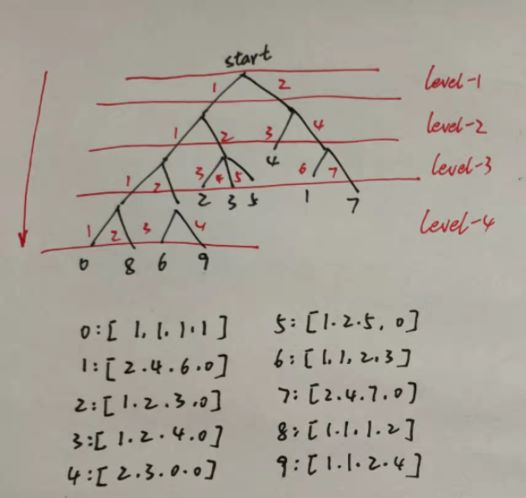

Where 0,1,...9 (in black) at the end of each branch represents the class label. The red 1,2,...7 indicates the path. The path of each class is given by the index of branches along its path, like class 4 is given by branch 2 at level 1, branch 3 at level 2, and no branches in level 3 and level 4, so the index is 0.

I chose the feature dimension to be 2, so it can be drawn in 2D plane. Accually I want the feature dimension to be a variable, a hyper parameter we can tune. But in this special case of feature dimension equals 2, I initiated the tree label by calculating angels.

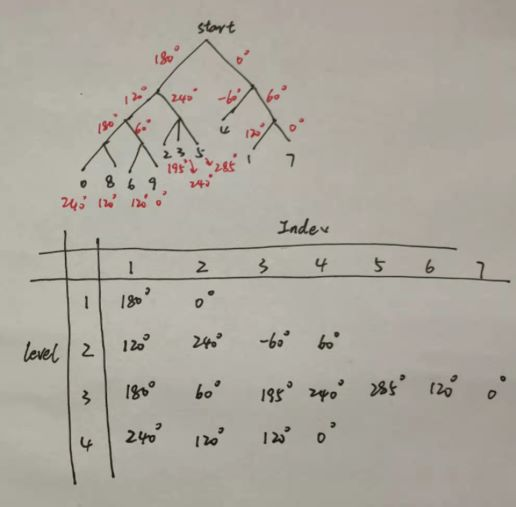

To plot the tree, I indexed each node.

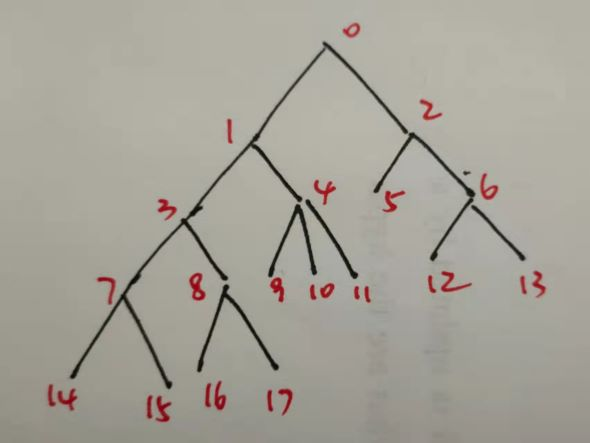

# Make Label

In [ ]:
label_index = torch.tensor([[1,1,1,1],[2,4,6,0],
               [1,2,3,4],[1,2,4,0],
               [2,3,0,0],[1,2,5,0],
               [1,1,2,3],[2,4,7,0],
               [1,1,1,2],[1,1,2,4]])

tree_angel = torch.tensor([[180,0,0,0,0,0,0],
              [120,240,-60,60,0,0,0],
              [180,60,195,240,285,120,0],
              [240,120,120,0,0,0,0]])

tree_length = [1,0.5,0.2,0.1]

ndepth = 4
max_branch = 7
nclass = 10


nIters = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Calculate vector for each branch
tree_vec = torch.zeros(ndepth,max_branch,2)
for i in range(ndepth):
  for j in range(max_branch):
    angel = tree_angel[i,j]/180*math.pi
    tree_vec[i,j,0] = math.cos(angel)
    tree_vec[i,j,1] = math.sin(angel)

In [ ]:
# Create the label vector using path and tree branch
label_vec = torch.zeros(nclass,2)
for i in range(nclass):
  for j in range(ndepth):
    vec_ind = label_index[i,j]-1
    label_vec[i,:] += tree_length[j]*tree_vec[j,vec_ind,:]

In [ ]:
# draw tree shape
def draw_tree_shape(tree_vec, tree_length, label_vec, line_color='k', dot_color='r'):
  tree_pts = torch.zeros(18,2)
  tree_pts[0,:] = torch.tensor([0,0])
  tree_pts[1,:] = tree_pts[0,:] + tree_vec[0,0,:]*tree_length[0]
  tree_pts[2,:] = tree_pts[0,:] + tree_vec[0,1,:]*tree_length[0]
  tree_pts[3,:] = tree_pts[1,:] + tree_vec[1,0,:]*tree_length[1]
  tree_pts[4,:] = tree_pts[1,:] + tree_vec[1,1,:]*tree_length[1]
  tree_pts[5,:] = tree_pts[2,:] + tree_vec[1,2,:]*tree_length[1]
  tree_pts[6,:] = tree_pts[2,:] + tree_vec[1,3,:]*tree_length[1]
  tree_pts[7,:] = tree_pts[3,:] + tree_vec[2,0,:]*tree_length[2]
  tree_pts[8,:] = tree_pts[3,:] + tree_vec[2,1,:]*tree_length[2]
  tree_pts[9,:] = tree_pts[4,:] + tree_vec[2,2,:]*tree_length[2]
  tree_pts[10,:] = tree_pts[4,:] + tree_vec[2,3,:]*tree_length[2]
  tree_pts[11,:] = tree_pts[4,:] + tree_vec[2,4,:]*tree_length[2]
  tree_pts[12,:] = tree_pts[6,:] + tree_vec[2,5,:]*tree_length[2]
  tree_pts[13,:] = tree_pts[6,:] + tree_vec[2,6,:]*tree_length[2]
  tree_pts[14,:] = tree_pts[7,:] + tree_vec[3,0,:]*tree_length[3]
  tree_pts[15,:] = tree_pts[7,:] + tree_vec[3,1,:]*tree_length[3]
  tree_pts[16,:] = tree_pts[8,:] + tree_vec[3,2,:]*tree_length[3]
  tree_pts[17,:] = tree_pts[8,:] + tree_vec[3,3,:]*tree_length[3]

  plt.plot([tree_pts[0,0],tree_pts[1,0]],[tree_pts[0,1],tree_pts[1,1]],line_color)
  plt.plot([tree_pts[0,0],tree_pts[2,0]],[tree_pts[0,1],tree_pts[2,1]],line_color)
  plt.plot([tree_pts[1,0],tree_pts[3,0]],[tree_pts[1,1],tree_pts[3,1]],line_color)
  plt.plot([tree_pts[1,0],tree_pts[4,0]],[tree_pts[1,1],tree_pts[4,1]],line_color)
  plt.plot([tree_pts[2,0],tree_pts[5,0]],[tree_pts[2,1],tree_pts[5,1]],line_color)
  plt.plot([tree_pts[2,0],tree_pts[6,0]],[tree_pts[2,1],tree_pts[6,1]],line_color)
  plt.plot([tree_pts[3,0],tree_pts[7,0]],[tree_pts[3,1],tree_pts[7,1]],line_color)
  plt.plot([tree_pts[3,0],tree_pts[8,0]],[tree_pts[3,1],tree_pts[8,1]],line_color)
  plt.plot([tree_pts[4,0],tree_pts[9,0]],[tree_pts[4,1],tree_pts[9,1]],line_color)
  plt.plot([tree_pts[4,0],tree_pts[10,0]],[tree_pts[4,1],tree_pts[10,1]],line_color)
  plt.plot([tree_pts[4,0],tree_pts[11,0]],[tree_pts[4,1],tree_pts[11,1]],line_color)
  plt.plot([tree_pts[6,0],tree_pts[12,0]],[tree_pts[6,1],tree_pts[12,1]],line_color)
  plt.plot([tree_pts[6,0],tree_pts[13,0]],[tree_pts[6,1],tree_pts[13,1]],line_color)
  plt.plot([tree_pts[7,0],tree_pts[14,0]],[tree_pts[7,1],tree_pts[14,1]],line_color)
  plt.plot([tree_pts[7,0],tree_pts[15,0]],[tree_pts[7,1],tree_pts[15,1]],line_color)
  plt.plot([tree_pts[8,0],tree_pts[16,0]],[tree_pts[8,1],tree_pts[16,1]],line_color)
  plt.plot([tree_pts[8,0],tree_pts[17,0]],[tree_pts[8,1],tree_pts[17,1]],line_color)
  for i in range(18):
    plt.scatter(tree_pts[i,0], tree_pts[i,1],c=dot_color)
  for i in range(10):
    plt.text(label_vec[i,0], label_vec[i,1] ,str(i),fontsize=20, verticalalignment="bottom", horizontalalignment="right")
  plt.text(0, 0 ,'start', fontsize=20, verticalalignment="top", horizontalalignment="center")
  plt.xlim(-2,2) 
  plt.ylim(-1,1)

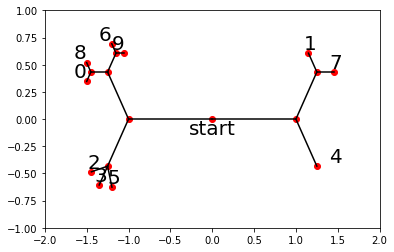

In [ ]:
draw_tree_shape(tree_vec, tree_length, label_vec)

# Train

In [ ]:
from torchvision import datasets, models
import torch.nn as nn

In [ ]:
ResNet50 = models.resnet50(pretrained=False)
fc_inputs = ResNet50.fc.in_features
ResNet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,256),
    nn.ReLU(),
    nn.Linear(256,10),
    nn.ReLU(),
    nn.Linear(10,2))

In [ ]:
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
data_train = datasets.CIFAR10(root = "./data/", train = True, transform=transform, download = True)
data_test = datasets.CIFAR10(root="./data/", train = False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size = 10000, shuffle = True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size = 10000, shuffle = True, drop_last=True)

Files already downloaded and verified


In [ ]:
def train_epoch(epoch, data_loader, model, loss_func, optimizer):
  for (X, y) in data_loader:
    label = label_vec[y.reshape(-1,1),:].squeeze().to(device)
    optimizer.zero_grad()
    output = model.forward(X.to(device))
    loss = loss_func(output, label)
    loss_hist[epoch] += loss
    loss.backward()
    optimizer.step()
  if (epoch+1)%5 == 0:
    print('Round', str(epoch+1)+'/'+str(nIters),', Loss: ', round(loss_hist[epoch].item(),5))

In [ ]:
model = ResNet50.to(device)

# TODO: implement loss function and probably new optimizer ()
loss_func = nn.MSELoss()
optmizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

run_name = 'run-'+ str(time.time())
result_path = path+'/results/' + run_name + '/'
train_val_metrics_path = result_path + 'train_val_metrics/'
model_path = result_path + 'saved_model.pt'
if not os.path.exists(result_path):
    os.makedirs(result_path)
    os.mkdir(train_val_metrics_path)

loss_hist = torch.zeros(nIters).to(device)
# TODO: define config for variables like num epochs
for epoch in range(0, nIters):
  train_epoch(epoch, train_loader, model, loss_func, optmizer)

torch.save(model.state_dict(), model_path)

Round 5/100 , Loss:  4.19018
Round 10/100 , Loss:  1.18107
Round 15/100 , Loss:  0.64405
Round 20/100 , Loss:  0.34286
Round 25/100 , Loss:  0.17055
Round 30/100 , Loss:  0.11265
Round 35/100 , Loss:  0.07135
Round 40/100 , Loss:  0.04781
Round 45/100 , Loss:  0.03488
Round 50/100 , Loss:  0.02488
Round 55/100 , Loss:  0.01692
Round 60/100 , Loss:  0.01674
Round 65/100 , Loss:  0.01702
Round 70/100 , Loss:  0.01373
Round 75/100 , Loss:  0.00929
Round 80/100 , Loss:  0.00985
Round 85/100 , Loss:  0.00896
Round 90/100 , Loss:  0.00686
Round 95/100 , Loss:  0.00569
Round 100/100 , Loss:  0.00969


Text(0.5, 1.0, 'Training Loss')

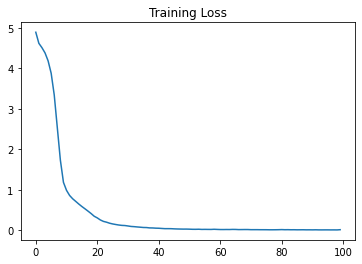

In [ ]:
plt.plot(torch.arange(nIters), loss_hist.cpu().detach().numpy())
plt.title('Training Loss')

# Test

In [ ]:
def vector_to_prediction(output, label_vec):
  # output (B, feature_dim)
  # label_vec (N, feature_dim)

  diff = output.unsqueeze(1) - label_vec.cuda().unsqueeze(0) #(B, N, feature_dim)
  diff = torch.sum(diff**2,2)
  return torch.argmin(diff,dim=1)

In [ ]:
def test_model(train_loader, test_loader, model, loss_func, result_path):
  # Evaluate model on test set
  out_path = result_path + '/'
  test_preds, train_preds = [], []
  train_losses, test_losses = [], []
  num_correct_test = 0
  num_correct_train = 0

  for X,y in train_loader:
    with torch.no_grad():
      output_vector = model(X.to(device))
      label_vector = label_vec[y.reshape(-1,1),:].squeeze().to(device)

      prediction = vector_to_prediction(output_vector, label_vec)
      loss = loss_func(output_vector, label_vector)
      train_preds.append(prediction)
      train_losses.append(loss.item())
      #print(prediction == y.to(device))
      num_correct_train += int(torch.sum(prediction == y.to(device)))
  for X,y in test_loader:
    with torch.no_grad():
      output_vector = model(X.to(device))
      label_vector = label_vec[y.reshape(-1,1),:].squeeze().to(device)

      prediction = vector_to_prediction(output_vector, label_vec)
      loss = loss_func(output_vector, label_vector)
      test_preds.append(prediction)
      test_losses.append(loss.item())
      num_correct_test += int(torch.sum(prediction == y.to(device)))

  train_loss = np.mean(train_losses)
  train_acc = num_correct_train/50000
  test_loss = np.mean(test_losses)
  test_acc = num_correct_test/10000

  #print('Performance Metrics for epoch ' + str(epoch_num) + ':')
  print('train loss: ' + str(round(train_loss,3)))
  print('test loss: ' + str(round(test_loss,3)))
  print('train accuracy: ' + str(round(train_acc*100,3))+'%')
  print('test accuracy: ' + str(round(test_acc*100,3))+'%')

  with open(result_path + 'test_model.csv', 'w') as csvfile:
    fieldnames = ['train_loss', 'train_acc', 'test_loss', 'test_acc']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc})

In [ ]:
test_model(train_loader, test_loader, model, loss_func, train_val_metrics_path)

train loss: 0.001
test loss: 1.231
train accuracy: 97.63%
test accuracy: 19.68%
